In [3]:
#imports
import os
import requests
import zipfile
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from pycocotools.coco import COCO
from tqdm import tqdm

In [13]:
#COCO paths 
img_dir = "/Users/sakprave/Downloads/Coco/images/train2017"
annFile = "/Users/sakprave/Downloads/Coco/annotations/instances_train2017.json"

coco = COCO(annFile)
image_ids = coco.getImgIds()[1000:1010]  # Get first 10 images


loading annotations into memory...
Done (t=11.48s)
creating index...
index created!


In [34]:
#To visualise ground truth images
def show_ground_truth(image_id):
    img_info = coco.loadImgs(image_id)[0]
    img_path = f"{img_dir}/{img_info['file_name']}"
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    coco.showAnns(anns)
    plt.axis('off')
    plt.title("Ground Truth")
    plt.show()


In [15]:
#loading model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device).eval()

transform = T.Compose([T.ToTensor()])

In [35]:
#Predicting bounding boxes and visualising the boxes
def predict_and_visualize(image_id, threshold=0.5):
    img_info = coco.loadImgs(image_id)[0]
    img_path = f"{img_dir}/{img_info['file_name']}"
    
    image = Image.open(img_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)

    boxes = outputs[0]['boxes'].cpu().numpy()
    scores = outputs[0]['scores'].cpu().numpy()
    labels = outputs[0]['labels'].cpu().numpy()

    image_np = np.array(image).copy()

    for box, score, label in zip(boxes, scores, labels):
        if score >= threshold:
            x1, y1, x2, y2 = box.astype(int)
            cv2.rectangle(image_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
            class_name = coco.loadCats([int(label)])[0]['name']
            cv2.putText(image_np, f'{class_name}: {score:.2f}', (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    plt.figure(figsize=(4, 4))
    plt.imshow(image_np)
    plt.title("Predictions")
    plt.axis('off')
    plt.show()

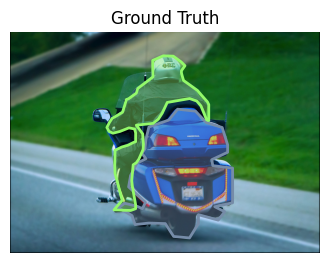

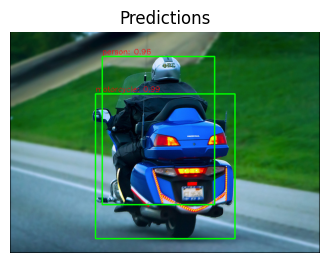

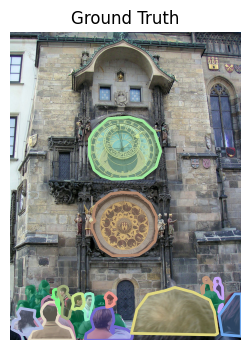

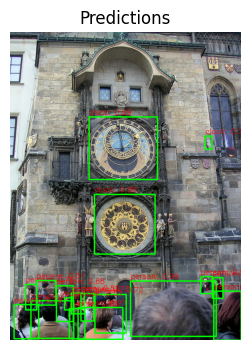

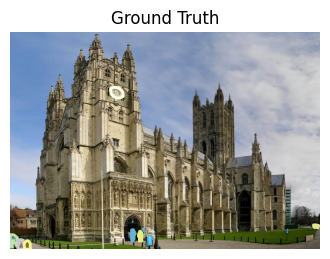

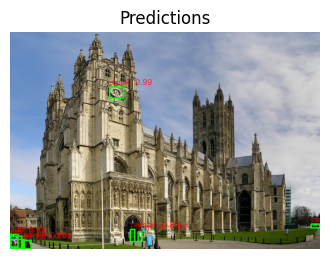

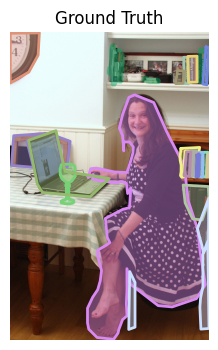

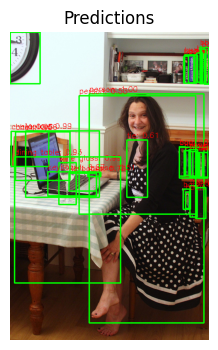

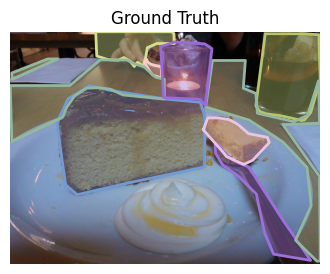

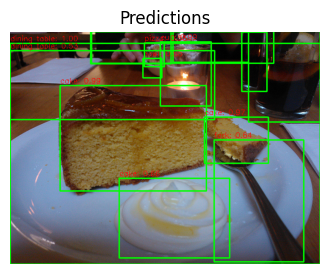

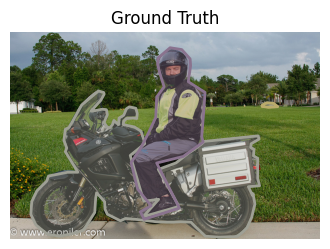

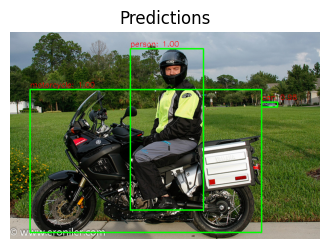

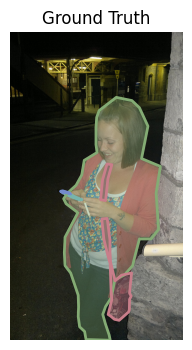

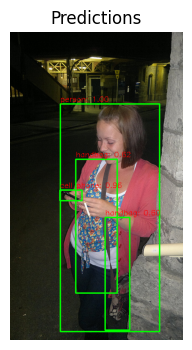

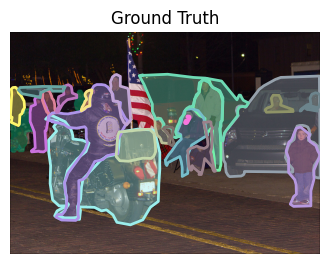

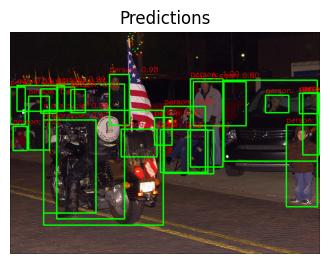

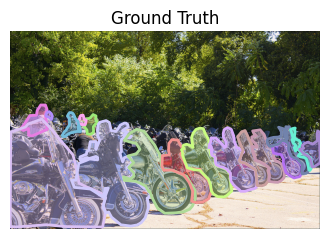

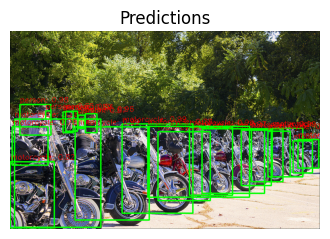

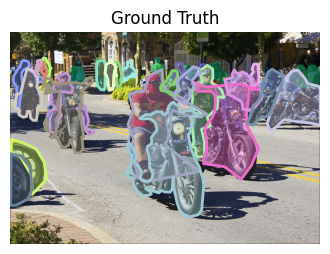

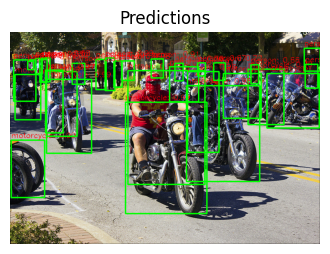

In [36]:
for img_id in image_ids:
    show_ground_truth(img_id)
    predict_and_visualize(img_id)